Notebook to generate data file that is a subset of the SGA catalog with rotational velocities measured during Y1 (iron).

In [1]:
import numpy as np

from astropy.table import Table, join
from astropy.coordinates import SkyCoord, SkyOffsetFrame
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
dv_sys = 7 # km/s
dz_sys = dv_sys/c.value
#### ultimately dz = (1+z) dv/c, but we will multiply this by (1+z) for each observation

In [3]:
dz_sys

np.float64(2.3349486663870643e-05)

# Data

## iron

In [4]:
tiron = Table.read('desi_pv_tf_iron_healpix.fits')
# tiron = Table.read('/Users/kdouglass/Documents/Research/data/DESI/Y1/desi_pv_tf_iron_healpix.fits')
tiron[:5]
print(tiron.colnames)

['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'HEALPIX', 'SURVEY', 'Z', 'ZERR', 'ZWARN', 'DELTACHI2', 'FILENAME', 'PVTYPE', 'SGA_ID', 'RA', 'DEC']


### Life is simpler if we apply quality cuts now

I added a minimum zerr criterion since there is a detatched clump close to zero error.

In [5]:
tiron = tiron[(tiron['DELTACHI2'] > 25) & (tiron['ZWARN'] == 0) & (tiron['ZERR'] > 1e-7)]

In [6]:
iron_VI = Table.read('iron_VI.txt', format='ascii.commented_header')

axis_VI = np.ones(len(tiron), dtype=bool)

for targetid in iron_VI['TARGETID']:
    
    if targetid in tiron['TARGETID']:
        axis_VI = axis_VI & (tiron['TARGETID'] != targetid)
        
tiron = tiron[axis_VI]
print(len(np.unique(tiron['SGA_ID'])), len(tiron))

73228 93095


### Update all Redrock uncertainties to account for 7 km/s statistical uncertainty

In [7]:
tiron['ZERR_MOD'] = np.sqrt(tiron['ZERR']**2 + (dz_sys*(1+tiron['Z']))**2)

### Are $\sigma_z$ small relative to $z$?

In [8]:
np.max(tiron['ZERR_MOD']/tiron['Z'])

np.float64(38.776587730091535)

Text(0, 0.5, 'count')

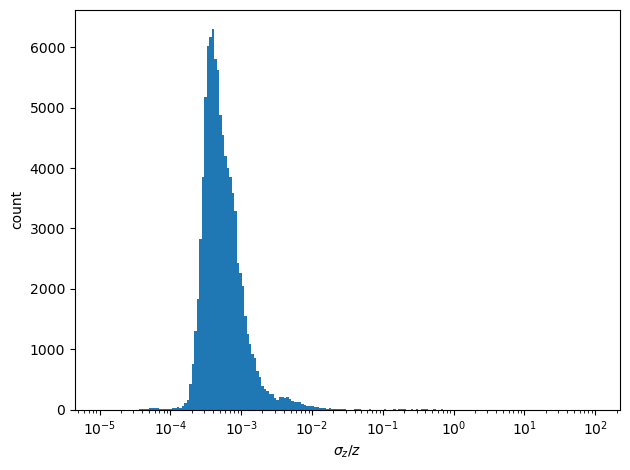

In [9]:
plt.figure(tight_layout=True)

plt.hist(tiron['ZERR_MOD']/tiron['Z'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count')

## SGA

In [10]:
SGA = Table.read('SGA-2020.fits', 'ELLIPSE')
# SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [11]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

### One addition to Kelly's code is to keep track of objects with both center and R=0.4 measurements.

Not sure it is really needed.  I was using it to help debug

In [12]:
tiron['SKY_FIBER_DIST'] = 0.
tiron['SKY_FIBER_DIST_R26'] = 0.
tiron['AXIS_SIDE'] = 0
tiron['center_and_axis'] = False
SGA['center_and_axis'] = False

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tiron['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tiron['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    SGA_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][SGA_idx], 
                          dec=SGA['DEC'][SGA_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tiron['RA'][obs_idx], 
                             dec=tiron['DEC'][obs_idx], 
                             unit=u.degree)

    # calculation of side of line
    # 1) Project all fibers into a small‐angle (tangent) plane about the galaxy center
    plane = target_coords.transform_to(SkyOffsetFrame(origin=SGA_coords))

    # 2) Extract flat coordinates in arcsec
    x = plane.lon.arcsec   # east–west offset
    y = plane.lat.arcsec   # north–south offset

    # 3) Define dividing line usint the first point as a direction vector
    dx_line, dy_line = x[0], y[0]

    dot = dx_line * x + dy_line * y

    # 5) Convert to +1/−1 labels
    side = np.sign(dot).astype(int)

    # 6) Store back into your table
    tiron['AXIS_SIDE'][obs_idx] = side

    #calculation of distance
    sep2d = target_coords.separation(SGA_coords)
    tiron['SKY_FIBER_DIST'][obs_idx] = sep2d
    tiron['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][SGA_idx]*u.arcmin)
    SGA['center_and_axis'][SGA_idx] = (
        ((tiron['SKY_FIBER_DIST_R26'][obs_idx] < 0.1).sum() > 0) & 
        ((
            ((tiron['SKY_FIBER_DIST_R26'][obs_idx] > 0.38)) & ((tiron['SKY_FIBER_DIST_R26'][obs_idx] < 0.42))
        ).sum() > 0))
    tiron['center_and_axis'][obs_idx] = SGA['center_and_axis'][SGA_idx]
    #---------------------------------------------------------------------------

100%|██████████| 73228/73228 [01:51<00:00, 657.20it/s]


In [13]:
print(SGA['center_and_axis'].sum(), tiron['center_and_axis'].sum())

10039 24992


In [14]:
tiron = tiron[tiron['center_and_axis']]

### split into center and axis observations

In [15]:
centers_boolean = tiron['SKY_FIBER_DIST_R26'] < 0.1

iron_centers = tiron[centers_boolean]
iron_axis = tiron[~centers_boolean]

good_centers = iron_centers
good_axis = iron_axis

good_centers_VI = iron_centers
good_axis_VI = iron_axis

## Clean the iron center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0
* passed VI

These are done upstream

In [16]:
# good_centers = iron_centers[(iron_centers['DELTACHI2'] > 25) & (iron_centers['ZWARN'] == 0)]
# print(len(np.unique(good_centers['SGA_ID'])), len(good_centers))

In [17]:
# iron_VI = Table.read('iron_VI.txt', format='ascii.commented_header')

# axis_VI = np.ones(len(good_centers), dtype=bool)

# for targetid in iron_VI['TARGETID']:
    
#     if targetid in good_centers['TARGETID']:
#         axis_VI = axis_VI & (good_centers['TARGETID'] != targetid)
        
# good_centers_VI = good_centers[axis_VI]
# print(len(np.unique(good_centers_VI['SGA_ID'])), len(good_centers_VI))

### How does $\sigma_z$ compare with $z$ for the good center observations?

In [18]:
# print(np.max(good_axis['ZERR_MOD']/good_axis['Z']), np.max(iron_centers['ZERR_MOD']/iron_centers['Z']))

Text(0, 0.5, 'count')

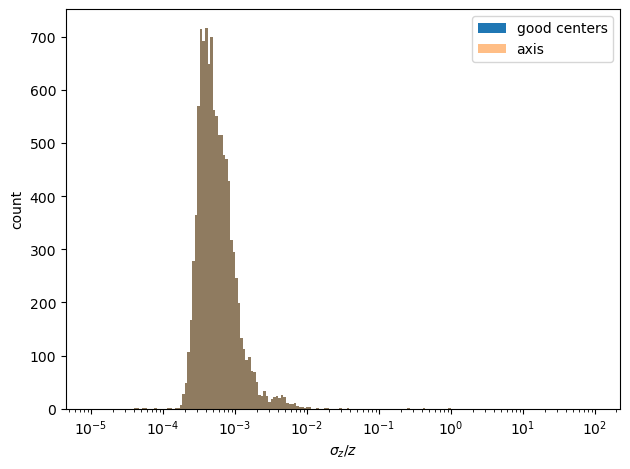

In [19]:
plt.figure(tight_layout=True)

plt.hist(good_centers['ZERR_MOD']/good_centers['Z'], bins=np.logspace(-5, 2, 200), label='good centers')
plt.hist(iron_centers['ZERR_MOD']/iron_centers['Z'], bins=np.logspace(-5, 2, 200), alpha=0.5, label='axis')

plt.xscale('log')

plt.legend()

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count')

### Should we be worried about these?

In [20]:
(good_centers['Z'] < 0).sum()

np.int64(4)

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [21]:
rng = np.random.default_rng()

N_samples = 10000 # for large error propagation

In [22]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

# weights = 1./(good_centers_VI['ZERR']**2)
weights = 1./(good_centers_VI['ZERR_MOD']**2)

for sga_id in tqdm(np.unique(good_centers_VI['SGA_ID'])):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers_VI['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers_VI['Z'][obs_idx], 
                                        weights=weights[obs_idx])

    # Compute the uncertainty in the center redshift
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

    # THIS MAKES NO SENSE
    # if N_obs == 1 or np.all(np.abs(good_centers_VI['ZERR_MOD'][obs_idx]/good_centers_VI['Z'][obs_idx]) < 0.05):
    #     SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./(N_obs*np.sum(weights[obs_idx])))
    # else:
    #     z_random = np.zeros((N_obs, N_samples))

    #     for i in range(N_obs):
    #         z_random[i] = rng.normal(loc=good_centers_VI['Z'][obs_idx][i], 
    #                                  scale=good_centers_VI['ZERR_MOD'][obs_idx][i], 
    #                                  size=N_samples)

    #     avg_z_random = np.average(z_random, 
    #                               weights=weights[obs_idx,None]*np.ones(N_samples), 
    #                               axis=0)
    #     SGA['ZERR_DESI'][SGA_idx] = np.std(avg_z_random)

100%|██████████| 10039/10039 [00:00<00:00, 12080.45it/s]


Text(0, 0.5, 'count')

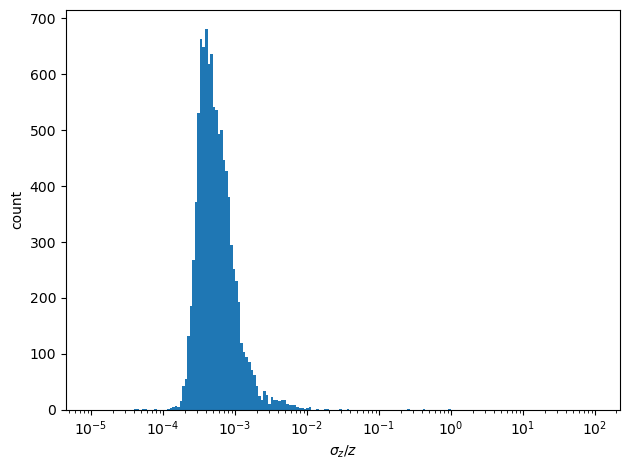

In [23]:
plt.figure(tight_layout=True)

plt.hist(SGA['ZERR_DESI']/SGA['Z_DESI'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count')

## Calculate the redshift of the axis

In [24]:
# good_axis = iron_axis[(iron_axis['DELTACHI2'] > 25) & (iron_axis['ZWARN'] == 0)]
# print(len(np.unique(good_axis['SGA_ID'])), len(good_axis))

### Calcluate Z_V = v/c

In [25]:
SGA['Z_C'] = np.nan
SGA['Z_V'] = np.nan
SGA['Z_V_ERR'] = np.nan
SGA['center_and_axis'] = False

for sga_id in tqdm(np.unique(good_axis_VI['SGA_ID'])):

    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_VI['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]

    use = obs_idx

    W_C = 1 / SGA['ZERR_DESI'][SGA_idx]**2
    W_A = (1 / good_axis_VI['ZERR_MOD'][use]**2).sum()
    S = (good_axis_VI['AXIS_SIDE'][use] / good_axis_VI['ZERR_MOD'][use]**2).sum()
    z_C = SGA['Z_DESI'][SGA_idx]/SGA['ZERR_DESI'][SGA_idx]**2 + (good_axis_VI['Z'][use]/good_axis_VI['ZERR_MOD'][use]**2).sum()
    z_A = (good_axis_VI['AXIS_SIDE'][use] * good_axis_VI['Z'][use]/good_axis_VI['ZERR_MOD'][use]**2).sum()
    SGA['Z_C'][SGA_idx] = (W_A * z_C - S * z_A) / (W_A*W_C + W_A**2 - S**2)
    SGA['Z_V'][SGA_idx] = ((W_C+W_A) * z_A - S * z_C) / (W_A*W_C + W_A**2 - S**2)
    z_V = SGA['Z_V'][SGA_idx]
    z_C = SGA['Z_C'][SGA_idx]
    SGA['Z_V_ERR'][SGA_idx] = np.sqrt( (W_C + (1 + z_V**2) * W_A + 2 * z_V * S)/( (1 + z_C)**2 * (W_A * (W_C + W_A) - S**2)))
    SGA['center_and_axis'][SGA_idx] = True

    # if np.abs(3e5* SGA['Z_V'][SGA_idx]) < 10:
    #     print(sga_id, W_C, W_A, S, z_C, z_A, SGA['Z_V'][SGA_idx], good_axis_VI['AXIS_SIDE'][use])



100%|██████████| 10039/10039 [00:02<00:00, 4601.59it/s]


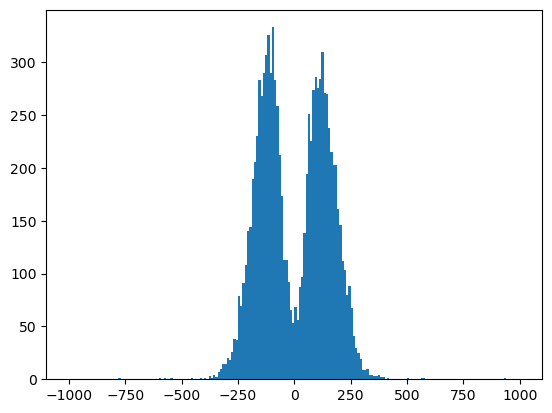

In [26]:
use = SGA['center_and_axis']
use = use 
plt.hist( 3e5*SGA['Z_V'][use],bins=200,range=(-1000,1000),);
# plt.xlabel(r'$v [km/s]$')

10039


Text(0, 0.5, '$v$ [km/s]')

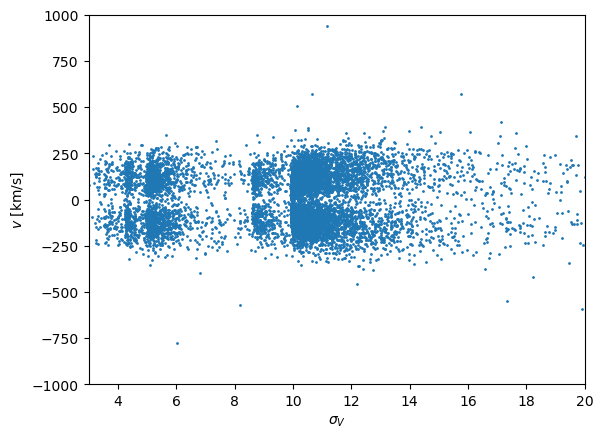

In [27]:
use = SGA['center_and_axis']
print(use.sum())
# strange = (SGA['Z_r0p4_ERR'] > 1.75e-5) &  (SGA['Z_r0p4_ERR'] < 1.95e-5) & (np.abs(SGA['V_ROT']) <20) 
plt.scatter(3e5* SGA['Z_V_ERR'][use], 3e5*SGA['Z_V'][use], s=1)
# plt.scatter(SGA['Z_r0p4_ERR'][use & strange], SGA['V_ROT'][use & strange], s=1, color='red')
plt.ylim(-1000, 1000)
plt.xlim(3,20)
plt.xlabel(r'$\sigma_V$')
plt.ylabel(r'$v$ [km/s]')

In [28]:
Vgood = (3e5*np.abs(SGA['Z_V']) < 1000) & (3e5*np.abs(SGA['Z_V']) > 10)
print(Vgood.sum())


9670


In [29]:
SGA_TF_local = SGA[Vgood]

In [30]:
#---------------------------------------------------------------------------
# Correct rotational velocities for inclination angle
#---------------------------------------------------------------------------
cosi2 = (SGA_TF_local['BA']**2 - q0**2)/(1 - q0**2)

# Galaxies with b/a < q0

cosi2[cosi2 < q0] = 0

SGA_TF_local['V_ROT_A'] = 3e5 * SGA_TF_local['Z_V'] / np.sin(np.arccos(np.sqrt(cosi2)))
SGA_TF_local['V_ROT_ERR_A'] = 3e5 * SGA_TF_local['Z_V_ERR'] / np.sin(np.arccos(np.sqrt(cosi2)))

In [31]:
SGA_TF_iron = Table.read('SGA-2020_iron_Vrot_VI_corr.fits')

In [32]:
result = join(SGA_TF_local, SGA_TF_iron, keys="SGA_ID", join_type="outer")

Text(0, 0.5, 'V_0p4R26')

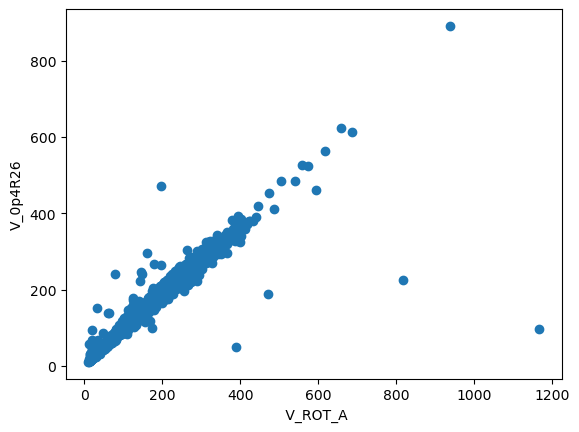

In [48]:
plt.scatter(np.abs(result['V_ROT_A']), result['V_0p4R26'])
plt.xlabel(' V_ROT_A')
plt.ylabel('V_0p4R26')


Text(0, 0.5, 'V_0p4R26_ERR - V_ROT_A_ERR')

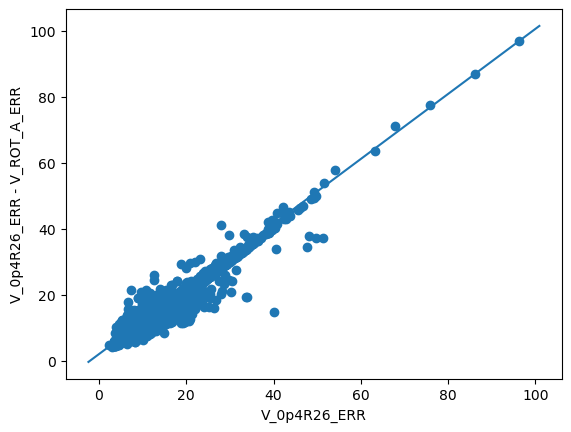

In [43]:
plt.scatter(result['V_ROT_ERR_A'], result['V_0p4R26_ERR'])
plt.plot(plt.xlim(), plt.ylim())
plt.xlabel('V_0p4R26_ERR')
plt.ylabel('V_0p4R26_ERR - V_ROT_A_ERR')


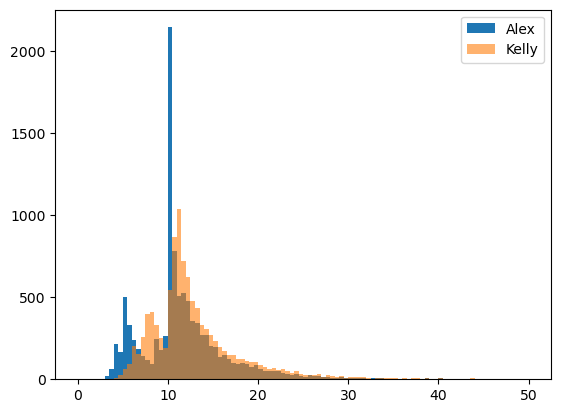

In [53]:
plt.hist(result['V_ROT_ERR_A'],bins=100, range=(0,50), label='Alex')
plt.hist(result['V_0p4R26_ERR'],bins=100, range=(0,50), label='Kelly', alpha=0.6)
plt.legend()

In [ ]:
( SGA['Z'][Vgood] < 0).sum()

np.int64(1)

# Calculate the rotational velocities

In [36]:
iron_axis['V_ROT'] = np.nan
iron_axis['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in tqdm(np.unique(good_centers_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = iron_axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center = SGA['ZERR_DESI'][sga_idx]

    # Calculate rotational velocity for all observations of the galaxy
    # iron_axis['V_ROT'][obs_idx] = c*(iron_axis['Z'][obs_idx] - z_center)
    z_rot = (1 + iron_axis['Z'][obs_idx])/(1 + z_center) - 1
    iron_axis['V_ROT'][obs_idx] = c*z_rot

    # Calculate uncertainty in the rotational velocity
    if np.all(np.abs(iron_axis['ZERR_MOD'][obs_idx]/iron_axis['Z'][obs_idx]) < 0.05) and (z_err_center/z_center < 0.05):
        # iron_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(iron_axis['ZERR'][obs_idx]**2 + z_err_center**2)
        # iron_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((iron_axis['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + iron_axis['Z'][obs_idx])/(1 + z_center)**2) + (dv_sys/c).value**2)
        iron_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((iron_axis['ZERR_MOD'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + iron_axis['Z'][obs_idx])/(1 + z_center)**2))
    else:
        z_center_random = rng.normal(loc=z_center, 
                                     scale=z_err_center,
                                     size=N_samples)

        z_axis_random = np.zeros((np.sum(obs_idx), N_samples))

        for i in range(np.sum(obs_idx)):
            z_axis_random[i] = rng.normal(loc=iron_axis['Z'][obs_idx][i], 
                                          scale=iron_axis['ZERR_MOD'][obs_idx][i], 
                                          size=N_samples)

        z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1

        iron_axis['V_ROT_ERR'][obs_idx] = np.std(np.abs(c*z_rot_random), axis=1)
    #---------------------------------------------------------------------------
    
    
    # #---------------------------------------------------------------------------
    # # Correct rotational velocities for inclination angle
    # #---------------------------------------------------------------------------
    # cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # # Galaxies with b/a < q0
    # if cosi2 < 0:
    #     cosi2 = 0
    
    # iron_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    # iron_axis['V_ROT_ERR'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

100%|██████████| 10039/10039 [00:01<00:00, 5171.39it/s]


[]

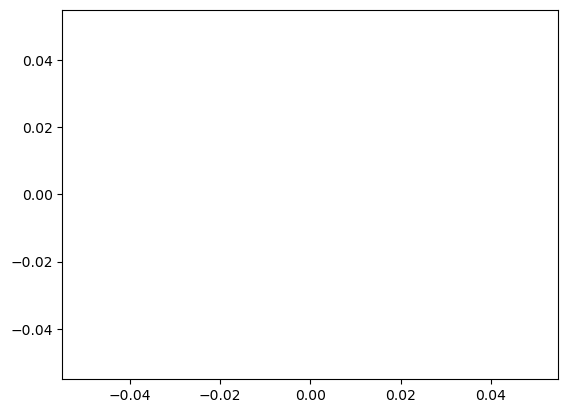

In [37]:
use = SGA['center_and_axis']
plt.plot()

In [38]:
use = SGA['center_and_axis']
small = SGA['V_ROT_ERR'] < 10
bins = np.linspace(-300, 300, 100)
plt.hist( SGA['V_ROT'][use & small], bins=bins, label=r'$\sigma_v < 10$ km/s',density=True)
plt.hist( SGA['V_ROT'][use & ~small], bins=bins, label=r'$\sigma_v >= 10$ km/s', density=True, alpha=0.7)

# plt.hist( 3e5*SGA['V_ROT'][use], range=((-3e2, 3e2)), bins=100)
plt.legend()
plt.xlabel(r'$v [km/s]$')
           

KeyError: 'V_ROT_ERR'

In [ ]:
use = SGA['center_and_axis']
small = SGA['ZERR_DESI'] < .3e-4
bins = np.linspace(-300, 300, 100)
plt.hist( SGA['V_ROT'][use & small], bins=bins, label=r'$\sigma_v < 10$ km/s',density=True)
plt.hist( SGA['V_ROT'][use & ~small], bins=bins, label=r'$\sigma_v >= 10$ km/s', density=True, alpha=0.7)

# plt.hist( 3e5*SGA['V_ROT'][use], range=((-3e2, 3e2)), bins=100)
plt.legend()
plt.xlabel(r'$v [km/s]$')

KeyError: 'ZERR_DESI'

Text(0.5, 0, 'Axis $\\sigma_z$')

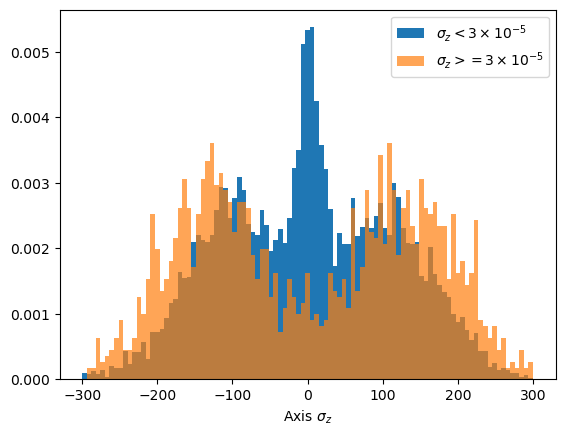

In [ ]:
use = SGA['center_and_axis']
small = SGA['Z_r0p4_ERR'] < .3e-4
bins = np.linspace(-300, 300, 100)
plt.hist( SGA['V_ROT'][use & small], bins=bins, label=r'$\sigma_z < 3\times 10^{-5}$',density=True)
plt.hist( SGA['V_ROT'][use & ~small], bins=bins, label=r'$\sigma_z >= 3\times 10^{-5}$', density=True, alpha=0.7)

# plt.hist( 3e5*SGA['V_ROT'][use], range=((-3e2, 3e2)), bins=100)
plt.legend()
plt.xlabel(r'Axis $\sigma_z$')

In [ ]:
use = SGA['center_and_axis']
small = SGA['Z_DESI'] < 0.05
bins = np.linspace(-300, 300, 100)
plt.hist( SGA['V_ROT'][use & small], bins=bins, label=r'$\sigma_v < 10$ km/s',density=True)
plt.hist( SGA['V_ROT'][use & ~small], bins=bins, label=r'$\sigma_v >= 10$ km/s', density=True, alpha=0.7)

# plt.hist( 3e5*SGA['V_ROT'][use], range=((-3e2, 3e2)), bins=100)
plt.legend()
plt.xlabel(r'$v [km/s]$')

KeyError: 'Z_DESI'

In [ ]:
use = SGA['center_and_axis']
small = SGA['D25_LEDA'] < 0.5
bins = np.linspace(-300, 300, 100)
plt.hist( SGA['V_ROT'][use & small], bins=bins, label=r'$\sigma_v < 10$ km/s',density=True)
plt.hist( SGA['V_ROT'][use & ~small], bins=bins, label=r'$\sigma_v >= 10$ km/s', density=True, alpha=0.7)

# plt.hist( 3e5*SGA['V_ROT'][use], range=((-3e2, 3e2)), bins=100)
plt.legend()
plt.xlabel(r'$v [km/s]$')

KeyError: 'V_ROT'

Text(0.5, 0, '$v [km/s]$')

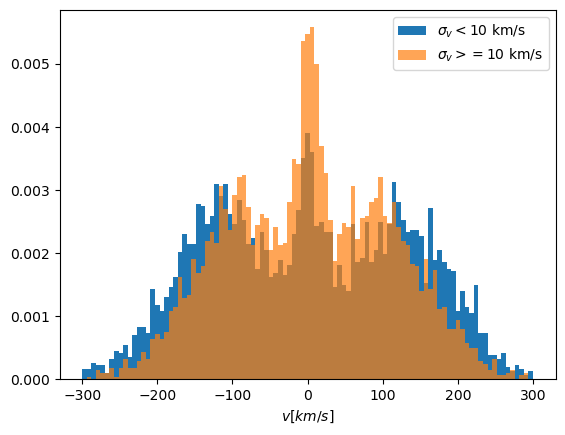

In [ ]:
use = SGA['center_and_axis']
small = SGA['BA_LEDA'] < 0.5
bins = np.linspace(-300, 300, 100)
plt.hist( SGA['V_ROT'][use & small], bins=bins, label=r'$\sigma_v < 10$ km/s',density=True)
plt.hist( SGA['V_ROT'][use & ~small], bins=bins, label=r'$\sigma_v >= 10$ km/s', density=True, alpha=0.7)

# plt.hist( 3e5*SGA['V_ROT'][use], range=((-3e2, 3e2)), bins=100)
plt.legend()
plt.xlabel(r'$v [km/s]$')

/var/folders/hr/9sdqv6450z16rzwk76fgsygw0000gn/T/ipykernel_24441/2714193316.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 0, '$v [km/s]$')

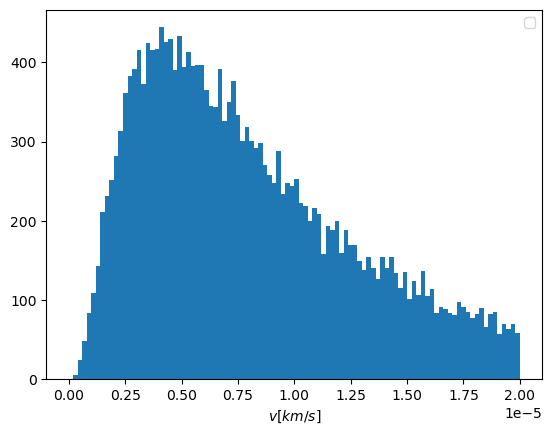

In [ ]:
use = SGA['center_and_axis']
plt.hist( tiron['ZERR'], bins=100, range=(0, 0.00002))

# plt.hist( 3e5*SGA['V_ROT'][use], range=((-3e2, 3e2)), bins=100)
plt.legend()
plt.xlabel(r'$v [km/s]$')

# Quality criteria for velocities

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.4R_{26}$
* $\Delta V / V_{min} \leq 5$
* passes VI

## Velocity cut

In [ ]:
r0p4 = (iron_axis['SKY_FIBER_DIST_R26'] > 0.38) & (iron_axis['SKY_FIBER_DIST_R26'] < 0.42)

Vgood = (np.abs(iron_axis['V_ROT']) < 1000) & (np.abs(iron_axis['V_ROT']) > 10)

good_axis = iron_axis[r0p4 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

KeyError: 'V_ROT'

## Visual inspection

Cutouts for this were generated with the `TF_Y1_VI.ipynb` notebook.

In [ ]:
axis_VI = np.ones(len(good_axis), dtype=bool)

for targetid in iron_VI['TARGETID']:
    
    if targetid in good_axis['TARGETID']:
        axis_VI = axis_VI & (good_axis['TARGETID'] != targetid)
        
good_axis_VI = good_axis[axis_VI]
print(len(good_axis_VI), len(np.unique(good_axis_VI['SGA_ID'])))

15060 10488


## Relative velocity cut

In [ ]:
good_deltaV = np.ones(len(good_axis_VI), dtype=bool)

for sga_id in tqdm(np.unique(good_axis_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_VI['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_VI['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_VI['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_VI['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_VI['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_VI['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_VI['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_VI['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_VI['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_VI['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_VI['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

100%|██████████| 10488/10488 [00:01<00:00, 6930.99it/s]


In [ ]:
good_deltaV_axis_VI = good_axis_VI[good_deltaV]

print(len(good_deltaV_axis_VI), len(np.unique(good_deltaV_axis_VI['SGA_ID'])))

15025 10478


# Compute the weighted average velocity for those galaxies with more than one observation at $0.4R_{26}$

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$

In [ ]:
SGA['V_0p4R26'] = np.nan
SGA['V_0p4R26_ERR'] = np.nan

weights = 1./(good_deltaV_axis_VI['V_ROT_ERR']**2)

for sga_id in tqdm(np.unique(good_deltaV_axis_VI['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_deltaV_axis_VI['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    SGA['V_0p4R26'][SGA_dict[sga_id]] = np.average(np.abs(good_deltaV_axis_VI['V_ROT'][obs_idx]), 
                                                   weights=weights[obs_idx])

    if N_obs == 1 or np.all(np.abs(good_deltaV_axis_VI['V_ROT_ERR'][obs_idx]/good_deltaV_axis_VI['V_ROT'][obs_idx]) < 0.05):
        SGA['V_0p4R26_ERR'][SGA_dict[sga_id]] = np.sqrt(1./(N_obs*np.sum(weights[obs_idx])))
    else:
        v_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            v_random[i] = rng.normal(loc=np.abs(good_deltaV_axis_VI['V_ROT'][obs_idx][i]), 
                                     scale=good_deltaV_axis_VI['V_ROT_ERR'][obs_idx][i], 
                                     size=N_samples)

        v_avg_random = np.average(v_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples),
                                  axis=0)
        SGA['V_0p4R26_ERR'][SGA_dict[sga_id]] = np.std(v_avg_random)

100%|██████████| 10478/10478 [00:04<00:00, 2260.97it/s]


In [ ]:
# Make a catalog of just those galaxies with velocities
SGA_TF_iron = SGA[np.isfinite(SGA['V_0p4R26']) & (SGA['R_MAG_SB26'] > 0)]

# Pull in `PHOTSYS` column

In [ ]:
photsys = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
# photsys = Table.read('SGA-2020_iron_Vrot_VI_photsys.fits')

In [ ]:
# SGA_TF_iron_photsys = join(SGA_TF_iron, photsys['SGA_ID', 'PHOTSYS'], 
                           keys='SGA_ID')

# Write final catalog to file

In [ ]:
# SGA_TF_iron.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot.fits')
# SGA_TF_iron_photsys.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits', 
SGA_TF_iron_photsys.write('SGA-2020_iron_Vrot_VI_corr.fits',
                          overwrite=True)

In [ ]:
#SGA_TF_iron_photsys.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys_v2.fits'

### Compare the updated vrot errors to the previous errors

In [ ]:
orig = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
mod = Table.read('SGA-2020_iron_Vrot_VI_corr.fits')

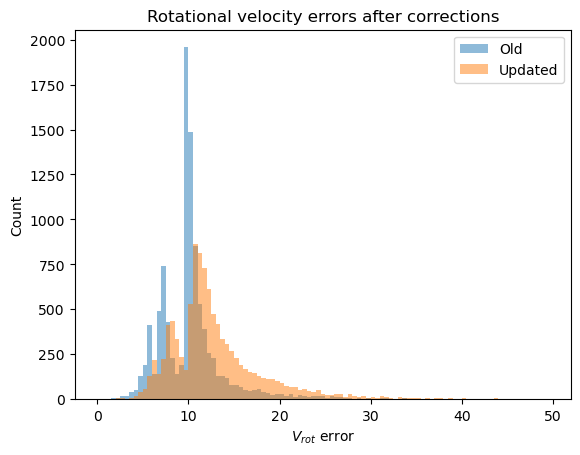

In [ ]:
plt.hist(orig['V_0p4R26_ERR'], bins=np.arange(0,50,0.5), alpha=0.5, label='Old')
plt.hist(mod['V_0p4R26_ERR'], alpha=0.5, bins=np.arange(0,50,0.5), label='Updated')
plt.title('Rotational velocity errors after corrections')
plt.xlabel(r'$V_{rot}$ error')
plt.ylabel('Count')
plt.legend()

(0.0, 60.0)

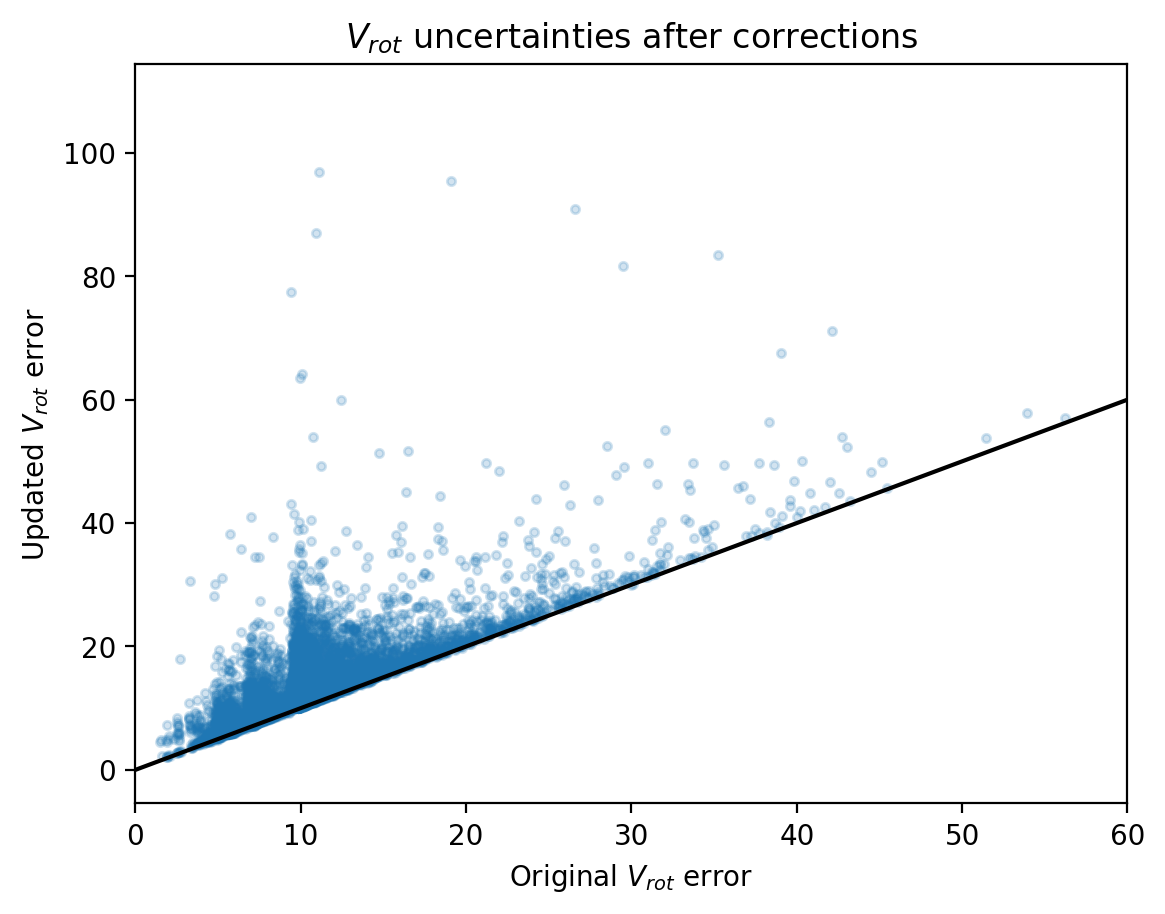

In [ ]:
plt.figure(dpi=200)
plt.errorbar(orig['V_0p4R26_ERR'], mod['V_0p4R26_ERR'], fmt='.' ,alpha=0.2)
# plt.hist(mod['V_0p4R26_ERR'], alpha=0.5, bins=np.arange(0,50,2), label='Updated')
xvals = np.linspace(0,60,1000)
plt.errorbar(xvals,xvals, color='k')
plt.title('$V_{rot}$ uncertainties after corrections')
plt.xlabel(r'Original $V_{rot}$ error')
plt.ylabel(r'Updated $V_{rot}$ error')
plt.xlim(0,60)
# plt.legend()

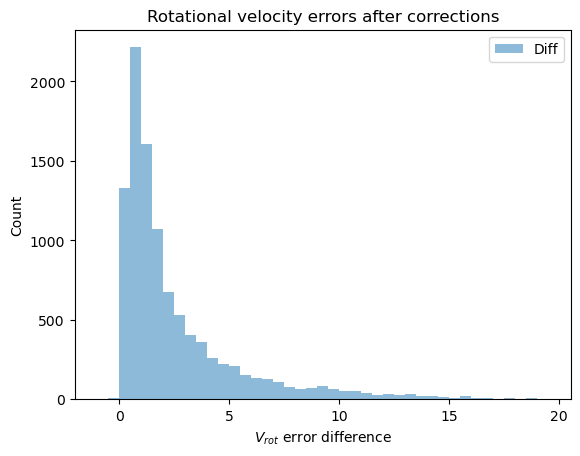

In [ ]:
plt.hist((mod['V_0p4R26_ERR'] - orig['V_0p4R26_ERR']), bins=np.arange(-1,20,0.5), alpha=0.5, label='Diff')
# plt.hist(mod['V_0p4R26_ERR'], alpha=0.5, bins=np.arange(0,50,2), label='Updated')
plt.title('Rotational velocity errors after corrections')
plt.xlabel(r'$V_{rot}$ error difference')
plt.ylabel('Count')
plt.legend()